In [1]:
import os
import requests
import json
import pandas as pd
import time
import matplotlib.pyplot as plt
from matplotlib import rc
from bs4 import BeautifulSoup
import nltk
from nltk import Text
from nltk.tag import pos_tag
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from konlpy.tag import Hannanum, Kkma, Komoran, Twitter, Okt
from wordcloud import WordCloud
from konlpy.corpus import kolaw
from keras_preprocessing.text import Tokenizer
import re
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, RNN, Dense

In [2]:
pd.set_option('display.max_rows', None)  # 최대 행 수 제한 해제
pd.set_option('display.max_columns', None)  # 최대 열 수 제한 해제
pd.set_option('display.width', None)  # 자동 너비 조정 해제
pd.set_option('display.max_colwidth', None)  # 최대 컬럼 너비 해제

In [3]:
os.environ.get('JAVA_HOME')

'/Library/Java/JavaVirtualMachines/jdk-17.jdk/Contents/Home'

In [4]:
%ls

KOSIS/
README.md
csv_file/
data_go_kr/
jpype1-1.5.1-cp312-cp312-macosx_10_9_universal2.whl
openAPI_자연어처리_RNN.ipynb


In [5]:
! pip install jpype1-1.5.1-cp312-cp312-macosx_10_9_universal2.whl

Processing ./jpype1-1.5.1-cp312-cp312-macosx_10_9_universal2.whl
jpype1 is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [6]:
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/imsehyeon/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/imsehyeon/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/imsehyeon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# openAPI를 이용하여 뉴스 기사 검색

In [7]:
# API 호출을 위한 설정
client_id = 'RgKYwTbMqCx5s9yGYqsT'
client_secret = '1INoZ2YkcD'
query = '흡연구역'
items_list = []

# 네이버 뉴스 API 호출
url = f'https://openapi.naver.com/v1/search/news.json?query={query}&display=30'
headers = {'X-Naver-Client-Id' : client_id, 'X-Naver-Client-Secret' : client_secret}
response = requests.get(url, headers=headers)

# 뉴스 아이템 리스트 추출
items = json.loads(response.text)['items']

# 각 뉴스의 제목, 링크, 설명, 본문을 추출
for item in items:
    title = item['title'].replace('<b>', '').replace('</b>', '').replace('&quot;', '')
    link = item['link']
    description = item['description'].replace('<b>', '').replace('</b>', '').replace('&quot;', '')
    
    # 본문 크롤링
    try:
        # 기사 페이지에 접속
        article_response = requests.get(link)
        article_soup = BeautifulSoup(article_response.text, 'html.parser')

        # 뉴스 본문 찾기 (일반적인 뉴스 페이지에서는 본문이 <div class="article_body">로 감싸져 있음)
        # 이 부분은 네이버 뉴스 페이지 구조에 따라 다를 수 있음
        article_content = article_soup.find('div', {'id': 'newsct_article'})
        if article_content:
            article_text = article_content.get_text().strip().replace('\n\n\n\n', '')
        else:
            article_text = "본문을 찾을 수 없습니다."
        
    except Exception as e:
        print(f"Error fetching article from {link}: {e}")
        article_text = "본문을 가져오는 데 실패했습니다."

    # 데이터 추가
    items_list.append([title, link, description, article_text])

# DataFrame으로 변환하여 출력
df = pd.DataFrame(items_list, columns=['title', 'link', 'description', 'content'])

Error fetching article from https://busanmbc.co.kr/01_new/new01_view.asp?idx=271002: HTTPSConnectionPool(host='busanmbc.co.kr', port=443): Max retries exceeded with url: /01_new/new01_view.asp?idx=271002 (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)')))


In [8]:
df

,title,link,description,content
0,"주택관리공단 부울지사, 금연사업 협력 '우수기관' 선정",https://www.gukjenews.com/news/articleView.html?idxno=3182764,지역 공공임대주택에서 생활터 금연지원서비스 적극 추진 △입주민 대상 금연캠페인 및 금연상담 프로그램 운영 △공공임대주택 내 상습 흡연구역 개선 △지역 사회와 연계한 중독 예방 캠페인 등이 꼽힌다.,본문을 찾을 수 없습니다.
1,"영동소방서, 겨울철 주유취급소 안전관리 실태 점검",http://www.bzeronews.com/news/articleView.html?idxno=695615,"또한 지난 해 개정된 위험물안전관리법에 따라 주유취급소 내 금연 구역 알림 표지 의무 설치 및 과태료 사항을 안내하고, 이용객들의 법령 미숙지로 인한 불이익이 없도록 흡연 금지 홍보물도 배부했다. 한편...",본문을 찾을 수 없습니다.
2,"금연거리 유명무실, 성숙한 시민의식 ‘절실’",https://www.jjan.kr/article/20250115580110,담배연기 없는 도시를 추구하기 위해 전국 각 지자체들이 실외까지 금연구역을 속속 확대하고 있지만 흡연자들의 비협조로 그 취지가 무색해지고 있다. 전주시도 ‘금연환경 조성 및 간접흡연 피해 방지 조례’를 제정해...,본문을 찾을 수 없습니다.
3,"영동소방서, 겨울철 주유취급소 안전관리 실태 점검",https://www.ggilbo.com/news/articleView.html?idxno=1069400,"또한, 지난해 개정된 위험물안전관리법에 따라 주유취급소 내 금연 구역 알림 표지 의무 설치 및 과태료 사항을 안내하고, 이용객들의 법령 미숙지로 인한 불이익이 없도록 흡연 금지 홍보물도 배부했다. 영동소방서는...",본문을 찾을 수 없습니다.
4,"영동소방서, 겨울철 주유취급소 안전관리 실태 점검",https://www.jbnews.com/news/articleView.html?idxno=1464192,"또한 지난 해 개정된 위험물안전관리법에 따라 주유취급소 내 금연 구역 알림 표지 의무 설치 및 과태료 사항을 안내하고, 이용객들의 법령 미숙지로 인한 불이익이 없도록 흡연 금지 홍보물도 배부했다. 한편...",본문을 찾을 수 없습니다.
5,달서구 금연구역 과태료 인상…21일부터 5만 원 (대구),http://ch1.skbroadband.com/content/view?parent_no=24&content_no=65&p_no=177128,"올해도 금연구역에서의 흡연행위에 대해 단속을 이어가는 동시에, 한편으로는 금연 홍보와 캠페인도 병행할 예정입니다. B tv 뉴스 천혜열입니다. (천혜열 기자 | rac@sk.com) (영상편집 | 이승환 기자 lbd1992@sk.com)...",본문을 찾을 수 없습니다.
6,"불의 날씨, 화석 연료 중독이 불러온 종말의 전조",https://newscham.net/articles/111672,비버 레이크 보호구역에는 식수를 트럭으로 운송해 와야 한다. 암과 호흡기 질환이 만연해 있다. 존... 이는 우리에게 매우 익숙해서 마치 1950년대 사람들이 비행기나 병원 대기실에서 흡연을 정상적으로 여겼던 것과...,본문을 찾을 수 없습니다.
7,"빅뱅 탑, 11년 만에 언론 인터뷰…마약→'오겜2' 연기력 논란 입 열까",https://www.topstarnews.net/news/articleView.html?idxno=15592808,"배역처럼 탑은 지난 2016년 대마초 흡연 혐의로 집행유예 2년을 선고받았다. 이로 인해 탑은 의경 신분에서 박탈돼 사회복무요원으로 재복무 했으나 특혜 의혹에 휘말렸고, 2019년 7월 마지막 출근날에는 장애인 주차구역에...",본문을 찾을 수 없습니다.
8,탑 '11년 만' 인터뷰… 빅뱅·마약·연기력 논란 답한다,https://m.entertain.naver.com/article/417/0001051968,"탑은 2016년 대마초 흡연 혐의로 집행유예 2년을 선고받았다. 이 사건으로 탑은 의경 신분에서 박탈돼 사회복무요원으로 재복무 했으나 특혜 의혹에 휘말렸고, 2019년 7월 마지막 출근날에는 장애인 주차구역에 차를 정차해...",본문을 찾을 수 없습니다.
9,"탑, 오늘(15일) 드디어 입 연다…빅뱅·마약→'오겜2' 인맥캐스팅·발연...",https://m.entertain.naver.com/article/076/0004235844,"탑은 2016년 대마초 흡연 혐의로 집행유예 2년을 선고받았다. 이 사건으로 탑은 의경 신분에서 박탈돼 사회복무요원으로 재복무 했으나 특혜 의혹에 휘말렸고, 2019년 7월 마지막 출근날에는 장애인 주차구역에 차를 정차해...",본문을 찾을 수 없습니다.


In [9]:
df['content'] = df['content'].replace('본문을 찾을 수 없습니다.', '-')
df

,title,link,description,content
0,"주택관리공단 부울지사, 금연사업 협력 '우수기관' 선정",https://www.gukjenews.com/news/articleView.html?idxno=3182764,지역 공공임대주택에서 생활터 금연지원서비스 적극 추진 △입주민 대상 금연캠페인 및 금연상담 프로그램 운영 △공공임대주택 내 상습 흡연구역 개선 △지역 사회와 연계한 중독 예방 캠페인 등이 꼽힌다.,-
1,"영동소방서, 겨울철 주유취급소 안전관리 실태 점검",http://www.bzeronews.com/news/articleView.html?idxno=695615,"또한 지난 해 개정된 위험물안전관리법에 따라 주유취급소 내 금연 구역 알림 표지 의무 설치 및 과태료 사항을 안내하고, 이용객들의 법령 미숙지로 인한 불이익이 없도록 흡연 금지 홍보물도 배부했다. 한편...",-
2,"금연거리 유명무실, 성숙한 시민의식 ‘절실’",https://www.jjan.kr/article/20250115580110,담배연기 없는 도시를 추구하기 위해 전국 각 지자체들이 실외까지 금연구역을 속속 확대하고 있지만 흡연자들의 비협조로 그 취지가 무색해지고 있다. 전주시도 ‘금연환경 조성 및 간접흡연 피해 방지 조례’를 제정해...,-
3,"영동소방서, 겨울철 주유취급소 안전관리 실태 점검",https://www.ggilbo.com/news/articleView.html?idxno=1069400,"또한, 지난해 개정된 위험물안전관리법에 따라 주유취급소 내 금연 구역 알림 표지 의무 설치 및 과태료 사항을 안내하고, 이용객들의 법령 미숙지로 인한 불이익이 없도록 흡연 금지 홍보물도 배부했다. 영동소방서는...",-
4,"영동소방서, 겨울철 주유취급소 안전관리 실태 점검",https://www.jbnews.com/news/articleView.html?idxno=1464192,"또한 지난 해 개정된 위험물안전관리법에 따라 주유취급소 내 금연 구역 알림 표지 의무 설치 및 과태료 사항을 안내하고, 이용객들의 법령 미숙지로 인한 불이익이 없도록 흡연 금지 홍보물도 배부했다. 한편...",-
5,달서구 금연구역 과태료 인상…21일부터 5만 원 (대구),http://ch1.skbroadband.com/content/view?parent_no=24&content_no=65&p_no=177128,"올해도 금연구역에서의 흡연행위에 대해 단속을 이어가는 동시에, 한편으로는 금연 홍보와 캠페인도 병행할 예정입니다. B tv 뉴스 천혜열입니다. (천혜열 기자 | rac@sk.com) (영상편집 | 이승환 기자 lbd1992@sk.com)...",-
6,"불의 날씨, 화석 연료 중독이 불러온 종말의 전조",https://newscham.net/articles/111672,비버 레이크 보호구역에는 식수를 트럭으로 운송해 와야 한다. 암과 호흡기 질환이 만연해 있다. 존... 이는 우리에게 매우 익숙해서 마치 1950년대 사람들이 비행기나 병원 대기실에서 흡연을 정상적으로 여겼던 것과...,-
7,"빅뱅 탑, 11년 만에 언론 인터뷰…마약→'오겜2' 연기력 논란 입 열까",https://www.topstarnews.net/news/articleView.html?idxno=15592808,"배역처럼 탑은 지난 2016년 대마초 흡연 혐의로 집행유예 2년을 선고받았다. 이로 인해 탑은 의경 신분에서 박탈돼 사회복무요원으로 재복무 했으나 특혜 의혹에 휘말렸고, 2019년 7월 마지막 출근날에는 장애인 주차구역에...",-
8,탑 '11년 만' 인터뷰… 빅뱅·마약·연기력 논란 답한다,https://m.entertain.naver.com/article/417/0001051968,"탑은 2016년 대마초 흡연 혐의로 집행유예 2년을 선고받았다. 이 사건으로 탑은 의경 신분에서 박탈돼 사회복무요원으로 재복무 했으나 특혜 의혹에 휘말렸고, 2019년 7월 마지막 출근날에는 장애인 주차구역에 차를 정차해...",-
9,"탑, 오늘(15일) 드디어 입 연다…빅뱅·마약→'오겜2' 인맥캐스팅·발연...",https://m.entertain.naver.com/article/076/0004235844,"탑은 2016년 대마초 흡연 혐의로 집행유예 2년을 선고받았다. 이 사건으로 탑은 의경 신분에서 박탈돼 사회복무요원으로 재복무 했으나 특혜 의혹에 휘말렸고, 2019년 7월 마지막 출근날에는 장애인 주차구역에 차를 정차해...",-


In [10]:
df = df[df['content'] != '-']
df

,title,link,description,content
13,“반차내고 아이 등교시켜”…과격한 한남동 집회에 초등학교 학생·학...,https://n.news.naver.com/mnews/article/005/0001751684?sid=102,흡연하는 시위 참가자들에게 경찰이 자리를 옮겨 달라고 요구하는 모습도 보였다. 학부모들은 불안감을... 집회금지구역으로 설정하게 돼 집회의 자유를 지나치게 제한하는 결과를 가져올 수 있다”고 판단했다. 문제는...,"14일 서울 용산구 한남초등학교에서 학생들이 하교하고 있다. 최현규 기자서울 한남동 대통령 관저 인근 학교 학생과 학부모가 연일 계속되는 집회에 골머리를 앓고 있다. 관저 주변에서 열리는 윤석열 대통령 탄핵 찬성 및 반대 집회에서 발생하는 소음뿐 아니라 일부 격앙된 시위 참여자의 비속어와 혐오 발언으로 험악한 분위기가 고조된 탓이다. 학생들 교육 환경에 악영향을 미칠 뿐 아니라 안전을 위협하는 환경이라는 지적이 나온다. 집회의 자유를 보장하면서도 학교 주변 집회에 대해선 소음 규제 등을 강화하는 대책 마련이 시급하다는 목소리가 커지고 있다.지난 13일 오후 1시쯤 찾은 한남동 서울한남초등학교는 방학기간이어서 정규 수업이 열리지는 않았다. 하지만 학생 100여명이 돌봄교실과 방과후학교 등을 다니고 있어서 학생들 통행이 끊이지 않는다. 학교 주변으로는 주로 3곳에서 집회가 진행된다. 학교 정문으로부터 300m쯤 떨어진 서울 지하철 6호선 한강진역 일대엔 보수 단체의 집회가 열린다. 정문에서 200m쯤 떨어진 곳에선 진보 단체의 집회가 진행된다.이들 2곳이 주요 집회 장소인데 학교 정문에서 불과 50m 떨어진 곳에서도 소규모로 탄핵 반대 집회가 열린다. 이 집회에선 한강진역 일대 집회 장면을 현장음과 함께 생중계한다. 밤낮을 가리지 않고 집회가 이어지면서 학교 주변은 내내 소음이 끊이지 않는다.14일 서울한남초등학교 정문 앞에 학생들의 안전한 등하교를 위한 경찰통제선이 설치되어있다. 최현규 기자학교 주변은 긴장감이 감돌았다. 학교 정문은 철문으로 굳게 닫혀 있었다. 학부모들과 학생들이 학교를 오갈 때만 잠시 정문 앞에서 대기하고 있던 교사가 문을 열어주면서 외부인 출입을 막고 있었다.정문 앞에는 형광 조끼를 입은 기동대 경찰 5명이 차량과 인파를 관리하고 있었다. 학교 담벼락에는 ‘우리 아이들 배움 위해 소리는 낮춰주세요’ ‘우리 아이들 위해 통학로는 지켜주세요’라는 내용의 현수막이 걸려 있었다.지난 13일 서울 용산구 한남초등학교 정문 앞 거리에 집회 참가자들이 몰려 있다. 일부 참가자들이 골목에서 담배를 피면서 정문 앞으로 담배 연기가 흘러 들어왔다. 최원준 기자일부 집회 참가자들은 정문 바로 앞에 자리를 잡고 있었다. 집회 관계자들이 현장 관리에 애를 쓴다고는 했으나 주변에는 쓰레기와 담배꽁초들이 나뒹굴고 있었다. 흡연하는 시위 참가자들에게 경찰이 자리를 옮겨 달라고 요구하는 모습도 보였다.학부모들은 불안감을 감추지 못했다. 올해 2학년 되는 학생을 둔 30대 여성 이모씨는 “지난주엔 학교 바로 앞으로 지금보다 사람이 더 많았는데 경찰이 등교 차량을 위해 길을 터 달라고 부탁했는데도 아무도 길을 열어주지 않았다”며 “결국 아이 손을 잡고 인파를 뚫으며 걸어갈 수밖에 없었는데 불안했다”고 말했다. 이씨는 “아이가 방과후학교만 다녀서 그나마 오후에 학교를 다니는데, 돌봄교실도 다녀야 해서 오전부터 아이를 학교에 보내야 하는 집도 있다”며 “그런 학부모들이 지금 제일 곤란해하고 있다”고 했다.불만이 커지고 있지만 집회를 통제할 뾰족한 방법을 찾기는 어렵다. 집회 및 시위에 관한 법률(집시법)에 따르면 학교 주변으로 집회가 신고돼 학습권이 뚜렷하게 침해될 우려가 있는 경우 관할 경찰서장은 시위를 금지할 수 있다고 규정돼 있다. 학교 주변 집회를 전면 금지하는 의무 조항이 아니다.집회의 자유를 중시하는 판례도 있다. 금속노조는 2014년 5월 27일 경찰청 맞은편으로 집회 신고를 냈다. 하지만 이틀 뒤 서울 남대문경찰서는 인근 이화여자외고의 학습권을 침해할 우려가 있다며 집회 금지 처분을 내렸다. 이에 금속노조는 서울행정법원에 옥외집회 금지 통고처분 취소소송을 냈고, 이듬해 4월 법원은 금속노조의 손을 들어줬다.법원은 “집회 신고 장소가 학교 주변 지역으로 볼 수 있지만, 학습권에 영향을 미칠 수 있는 학교 주변 지역을 모두 집회금지구역으로 설정하게 돼 집회의 자유를 지나치게 제한하는 결과를 가져올 수 있다”고 판단했다.14일 서울 한남초등학교 정문 앞에 탄핵 반대 종이 팻말이 붙어 있다. 최현규 기자문제는 학교 인근 집회가 폭력성을 띠는 경우가 적지 않다는 점이다. 지난 9일 서울한남초교 앞 집회 장소에선 스크린을 통해 연단에 올라온 연사의 험한 비속어가 그대로 생중계됐다. 13일도 마찬가지였다. 학교 주변엔 ‘사형’ 등 격한 문구들이 적힌 팻말과 깃발이 휘날리고 있었다. 14일 오전엔 홀로 등교하는 학생에게 한 집회 참가자가 말을 걸자 학생이 서둘러 정문으로 들어가며 피하는 모습도 보였다. 지난 10일 오전 11시쯤에는 4학년 자녀 손을 잡고 하교하던 40대 여성 김모씨가 “아이가 교실에서도 욕이 다 들린다고 한다. 길에서도 시위 참가자들이 큰 목소리로 고함을 쳐 무서워해 며칠간 반차를 내고 하굣길을 같이 한다”고 하소연했다.이씨도 “지난주에 방과후학교를 다녀온 아이가 너무 시끄럽고 무섭다며 울먹여 사흘 동안 아이를 학교에 보내지 않았다”며 “일반적인 집회면 모르겠는데, 주변 집회가 너무 격해서 도저히 아이를 혼자 등교시킬 수가 없다”고 했다.전문가들은 학교 앞 집회에 대한 조치가 필요하다고 지적했다. 이병훈 중앙대 사회학과 명예교수는 “집회 시위의 자유가 우선시돼야 하는 것은 맞지만 현재 학교 주변은 혐오 발언이 오가는 집회에 무방비 상태”라며 “스쿨존 제도를 도입했던 것을 집회에도 적용해야 한다”고 말했다. 그러면서 “현행법으로 학습권을 완전히 보장할 수 없다면, 시행령이나 시행규칙 등을 개정해서라도 거리와 소음기준 등을 새롭게 규제해 아이들의 정서를 보호해야 한다”고 강조했다."
18,“건전한 음주문화 정착”···김해 음주 폐해 예방 사업 ‘눈길’,https://n.news.naver.com/mnews/article/082/0001307242?sid=102,시 보건소 관계자는 “전통시장 인근에 조성된 분성광장은 어린이를 동반한 가족 단위 방문객 또는 어르신들이 자주 오가는 곳으로 평소 음주와 흡연 관련 불편 신고가 자주 접수됐다”면서 “금주 구역으로 지정되면...,"시, 분성광장 금주 구역 지정 추진음주·흡연 피해 민원 잦은 게 이유지역·대학 축제장서 홍보관 운영도“안전한 환경·시민 건강증진 목적”김해시보건소 전경. 김해시보건소 제공경남 김해시가 음주 관련 민원 다발 지역을 금주 구역으로 지정하고, 지역 축제 때 절주 홍보관을 운영하는 등 건전한 음주문화 정착에 집중한다.13일 김해시보건소에 따르면 시는 올해 음주 행위·소란으로 민원 발생이 잦은 동상동 분성광장을 금주 구역으로 지정하기로 했다. 현재는 주민 설문조사가 진행 중이며 향후 주민자치위원·유관기관 회의를 거쳐 시 조례를 근거로 절차를 밟아나갈 방침이다.김해에서는 앞서 2년 전 구산주공1단지아파트 놀이터와 상가 일대가 금주 구역으로 지정된 적이 있다. 보건소는 금주 구역 지정 요청이 들어오면 검토 후 확대 해나갈 예정이다.시 보건소 관계자는 “전통시장 인근에 조성된 분성광장은 어린이를 동반한 가족 단위 방문객 또는 어르신들이 자주 오가는 곳으로 평소 음주와 흡연 관련 불편 신고가 자주 접수됐다”면서 “금주 구역으로 지정되면 계도기간을 운영한 후 지도점검·단속을 벌일 계획”이라고 말했다.경남 김해시보건소가 발표한 ‘고위험 음주’ 안내문. 김해시 제공동시에 음주폐해예방 교육프로그램과 홍보체험관, 캠페인 등을 운영해 절주를 유도한다.교육프로그램은 김해시중독관리통합지원센터가 수탁 운영하며 아동·청소년·직장인 등 생애주기별, 생활터별로 나눠 교육·상담한다. 홍보체험관은 최근 지역 행사 또는 대학 축제와 연계해 운영 돼왔다. 음주폐해예방의 달은 11월로 기념 캠페인을 추진한다.시가 내놓은 ‘절주 실천 수칙’은 보건복지부와 

In [11]:
# 본문
content = df.iloc[:, 3]
content

13    14일 서울 용산구 한남초등학교에서 학생들이 하교하고 있다. 최현규 기자서울 한남동 대통령 관저 인근 학교 학생과 학부모가 연일 계속되는 집회에 골머리를 앓고 있다. 관저 주변에서 열리는 윤석열 대통령 탄핵 찬성 및 반대 집회에서 발생하는 소음뿐 아니라 일부 격앙된 시위 참여자의 비속어와 혐오 발언으로 험악한 분위기가 고조된 탓이다. 학생들 교육 환경에 악영향을 미칠 뿐 아니라 안전을 위협하는 환경이라는 지적이 나온다. 집회의 자유를 보장하면서도 학교 주변 집회에 대해선 소음 규제 등을 강화하는 대책 마련이 시급하다는 목소리가 커지고 있다.지난 13일 오후 1시쯤 찾은 한남동 서울한남초등학교는 방학기간이어서 정규 수업이 열리지는 않았다. 하지만 학생 100여명이 돌봄교실과 방과후학교 등을 다니고 있어서 학생들 통행이 끊이지 않는다. 학교 주변으로는 주로 3곳에서 집회가 진행된다. 학교 정문으로부터 300m쯤 떨어진 서울 지하철 6호선 한강진역 일대엔 보수 단체의 집회가 열린다. 정문에서 200m쯤 떨어진 곳에선 진보 단체의 집회가 진행된다.이들 2곳이 주요 집회 장소인데 학교 정문에서 불과 50m 떨어진 곳에서도 소규모로 탄핵 반대 집회가 열린다. 이 집회에선 한강진역 일대 집회 장면을 현장음과 함께 생중계한다. 밤낮을 가리지 않고 집회가 이어지면서 학교 주변은 내내 소음이 끊이지 않는다.14일 서울한남초등학교 정문 앞에 학생들의 안전한 등하교를 위한 경찰통제선이 설치되어있다. 최현규 기자학교 주변은 긴장감이 감돌았다. 학교 정문은 철문으로 굳게 닫혀 있었다. 학부모들과 학생들이 학교를 오갈 때만 잠시 정문 앞에서 대기하고 있던 교사가 문을 열어주면서 외부인 출입을 막고 있었다.정문 앞에는 형광 조끼를 입은 기동대 경찰 5명이 차량과 인파를 관리하고 있었다. 학교 담벼락에는 ‘우리 아이들 배움 위해 소리는 낮춰주세요’ ‘우리 아이들 위해 통학로는 지켜주세요’라는 내용의 현수막이 걸려 있었다.지난 13일 서울 용산구 한남초등학교 정문 앞 거리에 집회 

# NLTK 자연어처리

In [12]:
# 문장단위로 쪼갠 list
sent_tokens = sent_tokenize(str(content))
sent_tokens

['13    14일 서울 용산구 한남초등학교에서 학생들이 하교하고 있다.',
 '최현규 기자서울 한남동 대통령 관저 인근 학교 학생과 학부모가 연일 계속되는 집회에 골머리를 앓고 있다.',
 '관저 주변에서 열리는 윤석열 대통령 탄핵 찬성 및 반대 집회에서 발생하는 소음뿐 아니라 일부 격앙된 시위 참여자의 비속어와 혐오 발언으로 험악한 분위기가 고조된 탓이다.',
 '학생들 교육 환경에 악영향을 미칠 뿐 아니라 안전을 위협하는 환경이라는 지적이 나온다.',
 '집회의 자유를 보장하면서도 학교 주변 집회에 대해선 소음 규제 등을 강화하는 대책 마련이 시급하다는 목소리가 커지고 있다.지난 13일 오후 1시쯤 찾은 한남동 서울한남초등학교는 방학기간이어서 정규 수업이 열리지는 않았다.',
 '하지만 학생 100여명이 돌봄교실과 방과후학교 등을 다니고 있어서 학생들 통행이 끊이지 않는다.',
 '학교 주변으로는 주로 3곳에서 집회가 진행된다.',
 '학교 정문으로부터 300m쯤 떨어진 서울 지하철 6호선 한강진역 일대엔 보수 단체의 집회가 열린다.',
 '정문에서 200m쯤 떨어진 곳에선 진보 단체의 집회가 진행된다.이들 2곳이 주요 집회 장소인데 학교 정문에서 불과 50m 떨어진 곳에서도 소규모로 탄핵 반대 집회가 열린다.',
 '이 집회에선 한강진역 일대 집회 장면을 현장음과 함께 생중계한다.',
 '밤낮을 가리지 않고 집회가 이어지면서 학교 주변은 내내 소음이 끊이지 않는다.14일 서울한남초등학교 정문 앞에 학생들의 안전한 등하교를 위한 경찰통제선이 설치되어있다.',
 '최현규 기자학교 주변은 긴장감이 감돌았다.',
 '학교 정문은 철문으로 굳게 닫혀 있었다.',
 '학부모들과 학생들이 학교를 오갈 때만 잠시 정문 앞에서 대기하고 있던 교사가 문을 열어주면서 외부인 출입을 막고 있었다.정문 앞에는 형광 조끼를 입은 기동대 경찰 5명이 차량과 인파를 관리하고 있었다.',
 '학교 담벼락에는 ‘우리 아이들 배움 위해 소리는 낮춰주세요’ ‘우리 아이들 위해 통학로는 

In [13]:
# 단어단위로 쪼갠 list
word_tokened = word_tokenize(str(sent_tokens))
word_tokened

['[',
 "'13",
 '14일',
 '서울',
 '용산구',
 '한남초등학교에서',
 '학생들이',
 '하교하고',
 '있다',
 '.',
 "'",
 ',',
 "'최현규",
 '기자서울',
 '한남동',
 '대통령',
 '관저',
 '인근',
 '학교',
 '학생과',
 '학부모가',
 '연일',
 '계속되는',
 '집회에',
 '골머리를',
 '앓고',
 '있다',
 '.',
 "'",
 ',',
 "'관저",
 '주변에서',
 '열리는',
 '윤석열',
 '대통령',
 '탄핵',
 '찬성',
 '및',
 '반대',
 '집회에서',
 '발생하는',
 '소음뿐',
 '아니라',
 '일부',
 '격앙된',
 '시위',
 '참여자의',
 '비속어와',
 '혐오',
 '발언으로',
 '험악한',
 '분위기가',
 '고조된',
 '탓이다',
 '.',
 "'",
 ',',
 "'학생들",
 '교육',
 '환경에',
 '악영향을',
 '미칠',
 '뿐',
 '아니라',
 '안전을',
 '위협하는',
 '환경이라는',
 '지적이',
 '나온다',
 '.',
 "'",
 ',',
 "'집회의",
 '자유를',
 '보장하면서도',
 '학교',
 '주변',
 '집회에',
 '대해선',
 '소음',
 '규제',
 '등을',
 '강화하는',
 '대책',
 '마련이',
 '시급하다는',
 '목소리가',
 '커지고',
 '있다.지난',
 '13일',
 '오후',
 '1시쯤',
 '찾은',
 '한남동',
 '서울한남초등학교는',
 '방학기간이어서',
 '정규',
 '수업이',
 '열리지는',
 '않았다',
 '.',
 "'",
 ',',
 "'하지만",
 '학생',
 '100여명이',
 '돌봄교실과',
 '방과후학교',
 '등을',
 '다니고',
 '있어서',
 '학생들',
 '통행이',
 '끊이지',
 '않는다',
 '.',
 "'",
 ',',
 "'학교",
 '주변으로는',
 '주로',
 '3곳에서',
 '집회가',
 '진행된다',
 '.',
 "'",
 ',',
 "'

In [14]:
# 한글음절에 해당하는 문자만 추출
ret = RegexpTokenizer(r'[\uac00-\ud7a3]+')
words = ret.tokenize(str(word_tokened))
words

['일',
 '서울',
 '용산구',
 '한남초등학교에서',
 '학생들이',
 '하교하고',
 '있다',
 '최현규',
 '기자서울',
 '한남동',
 '대통령',
 '관저',
 '인근',
 '학교',
 '학생과',
 '학부모가',
 '연일',
 '계속되는',
 '집회에',
 '골머리를',
 '앓고',
 '있다',
 '관저',
 '주변에서',
 '열리는',
 '윤석열',
 '대통령',
 '탄핵',
 '찬성',
 '및',
 '반대',
 '집회에서',
 '발생하는',
 '소음뿐',
 '아니라',
 '일부',
 '격앙된',
 '시위',
 '참여자의',
 '비속어와',
 '혐오',
 '발언으로',
 '험악한',
 '분위기가',
 '고조된',
 '탓이다',
 '학생들',
 '교육',
 '환경에',
 '악영향을',
 '미칠',
 '뿐',
 '아니라',
 '안전을',
 '위협하는',
 '환경이라는',
 '지적이',
 '나온다',
 '집회의',
 '자유를',
 '보장하면서도',
 '학교',
 '주변',
 '집회에',
 '대해선',
 '소음',
 '규제',
 '등을',
 '강화하는',
 '대책',
 '마련이',
 '시급하다는',
 '목소리가',
 '커지고',
 '있다',
 '지난',
 '일',
 '오후',
 '시쯤',
 '찾은',
 '한남동',
 '서울한남초등학교는',
 '방학기간이어서',
 '정규',
 '수업이',
 '열리지는',
 '않았다',
 '하지만',
 '학생',
 '여명이',
 '돌봄교실과',
 '방과후학교',
 '등을',
 '다니고',
 '있어서',
 '학생들',
 '통행이',
 '끊이지',
 '않는다',
 '학교',
 '주변으로는',
 '주로',
 '곳에서',
 '집회가',
 '진행된다',
 '학교',
 '정문으로부터',
 '쯤',
 '떨어진',
 '서울',
 '지하철',
 '호선',
 '한강진역',
 '일대엔',
 '보수',
 '단체의',
 '집회가',
 '열린다',
 '정문에서',
 '쯤',
 '떨어진',
 '곳에선',
 '진보',
 '단체의',
 '집회가'

In [15]:
# 형태소 분석을 위한 어간 추출
pst = PorterStemmer()
pStemmed = pst.stem(str(words))
pStemmed

"['일', '서울', '용산구', '한남초등학교에서', '학생들이', '하교하고', '있다', '최현규', '기자서울', '한남동', '대통령', '관저', '인근', '학교', '학생과', '학부모가', '연일', '계속되는', '집회에', '골머리를', '앓고', '있다', '관저', '주변에서', '열리는', '윤석열', '대통령', '탄핵', '찬성', '및', '반대', '집회에서', '발생하는', '소음뿐', '아니라', '일부', '격앙된', '시위', '참여자의', '비속어와', '혐오', '발언으로', '험악한', '분위기가', '고조된', '탓이다', '학생들', '교육', '환경에', '악영향을', '미칠', '뿐', '아니라', '안전을', '위협하는', '환경이라는', '지적이', '나온다', '집회의', '자유를', '보장하면서도', '학교', '주변', '집회에', '대해선', '소음', '규제', '등을', '강화하는', '대책', '마련이', '시급하다는', '목소리가', '커지고', '있다', '지난', '일', '오후', '시쯤', '찾은', '한남동', '서울한남초등학교는', '방학기간이어서', '정규', '수업이', '열리지는', '않았다', '하지만', '학생', '여명이', '돌봄교실과', '방과후학교', '등을', '다니고', '있어서', '학생들', '통행이', '끊이지', '않는다', '학교', '주변으로는', '주로', '곳에서', '집회가', '진행된다', '학교', '정문으로부터', '쯤', '떨어진', '서울', '지하철', '호선', '한강진역', '일대엔', '보수', '단체의', '집회가', '열린다', '정문에서', '쯤', '떨어진', '곳에선', '진보', '단체의', '집회가', '진행된다', '이들', '곳이', '주요', '집회', '장소인데', '학교', '정문에서', '불과', '떨어진', '곳에서도', '소규모로', '탄핵', '반대', '집회가', '열린다', '이', '집회에선',

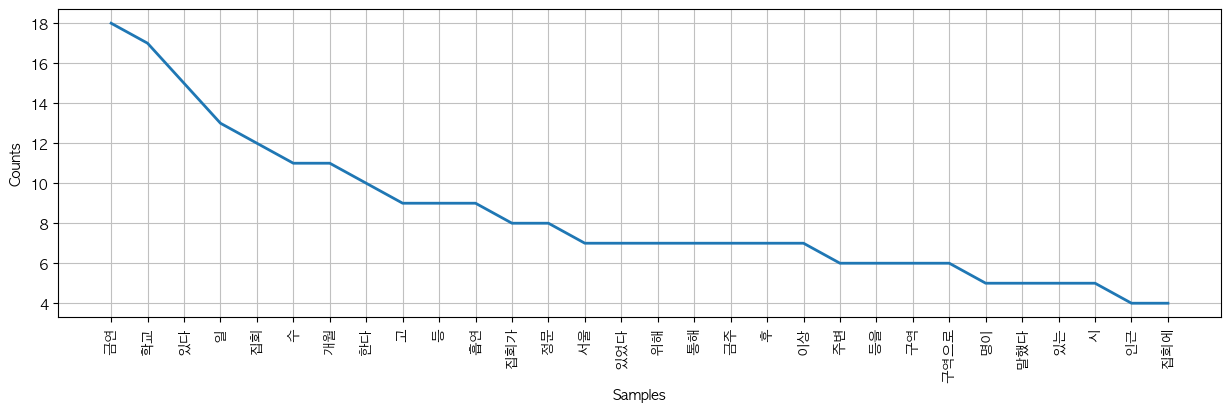

In [16]:
words = Text(words)
%matplotlib inline
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(15, 4))
words.plot(30)
plt.show()

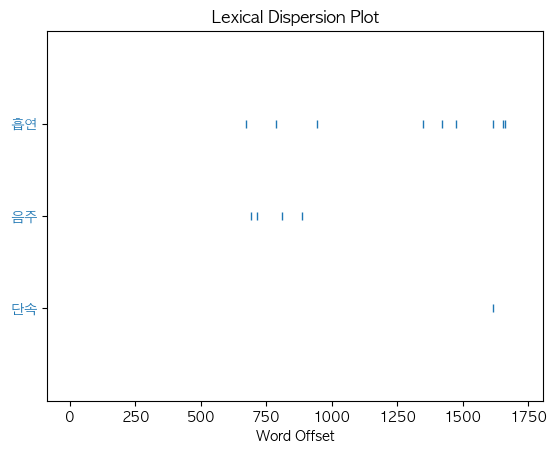

In [17]:
words.dispersion_plot(['흡연', '음주', '단속'])
plt.show()

# 한글 형태소 분석

In [18]:
text = ' '.join(words)

## Hannanum

In [19]:
hannanum = Hannanum(jvmpath=None, max_heap_size=1024)

In [20]:
hannanum.analyze(text)
# for word in words:
#     print(hannanum.analyze(word))

[[[('일', 'nbu')],
  [('일', 'ncn')],
  [('일', 'ncpa')],
  [('일', 'ncps')],
  [('일', 'nnc')],
  [('일', 'pvg'), ('ㄹ', 'etm')],
  [('이', 'pvg'), ('ㄹ', 'etm')]],
 [[('서울', 'ncn')], [('서울', 'nqq')]],
 [[('용산구', 'ncn')]],
 [[('한남', 'ncn'), ('초등학교', 'ncn'), ('에서', 'jca')],
  [('한남', 'ncn'), ('초등', 'ncn'), ('학교', 'ncn'), ('에서', 'jca')]],
 [[('학생', 'ncn'), ('들이', 'ncn')],
  [('학생', 'ncn'), ('들', 'ncn'), ('이', 'jcc')],
  [('학생', 'ncn'), ('들', 'ncn'), ('이', 'jcs')],
  [('학생', 'ncn'), ('들', 'xsncc'), ('이', 'jcc')],
  [('학생', 'ncn'), ('들', 'xsncc'), ('이', 'jcs')]],
 [[('하교', 'ncpa'), ('하고', 'jcj')],
  [('하교', 'ncpa'), ('하고', 'jct')],
  [('하교', 'ncpa'), ('하', 'xsva'), ('고', 'ecc')],
  [('하교', 'ncpa'), ('하', 'xsva'), ('고', 'ecs')],
  [('하교', 'ncpa'), ('하', 'xsva'), ('고', 'ecx')],
  [('하교', 'ncpa'), ('하', 'xsva'), ('어', 'ef'), ('고', 'jcr')]],
 [[('있', 'paa'), ('다', 'ef')], [('있', 'px'), ('다', 'ef')]],
 [[('최현규', 'ncn')], [('최현규', 'nqq')]],
 [[('기자서울', 'ncn')], [('기자서울', 'nqq')]],
 [[('한남동', 'ncn')], [(

In [21]:
# 형태소 분석
hannanum.morphs(text)

['일',
 '서울',
 '용산구',
 '한남초등학교',
 '에서',
 '학생들',
 '이',
 '하교',
 '하고',
 '있',
 '다',
 '최현규',
 '기자서울',
 '한남동',
 '대통령',
 '관저',
 '인근',
 '학교',
 '학생',
 '과',
 '학부모',
 '가',
 '연일',
 '계속',
 '되',
 '는',
 '집회',
 '에',
 '골머리',
 '를',
 '앓',
 '고',
 '있',
 '다',
 '관저',
 '주변',
 '에서',
 '열리',
 '는',
 '윤석열',
 '대통령',
 '탄핵',
 '찬성',
 '및',
 '반대',
 '집회',
 '에서',
 '발생',
 '하',
 '는',
 '소음',
 '뿐',
 '아니',
 '라',
 '일부',
 '격앙',
 '되',
 'ㄴ',
 '시위',
 '참여자',
 '의',
 '비',
 '속어',
 '와',
 '혐오',
 '발언',
 '으로',
 '험악한',
 '분위기',
 '가',
 '고조',
 '되',
 'ㄴ',
 '탓',
 '이',
 '다',
 '학생들',
 '교육',
 '환경',
 '에',
 '악영향',
 '을',
 '미치',
 'ㄹ',
 '뿐',
 '아니',
 '라',
 '알',
 'ㄴ',
 '전',
 '을',
 '위협',
 '하',
 '는',
 '환경',
 '이',
 '라는',
 '지적',
 '이',
 '나',
 '아',
 '오',
 'ㄴ다',
 '집회',
 '의',
 '자유',
 '를',
 '보장하',
 '이',
 '면서',
 '도',
 '학교',
 '주변',
 '집회',
 '에',
 '대',
 '어',
 '하',
 '어서ㄴ',
 '소음',
 '규제',
 '등',
 '을',
 '강화',
 '하',
 '는',
 '대책',
 '마련',
 '이',
 '시급',
 '하',
 '다는',
 '목소리',
 '가',
 '크',
 '어',
 '지',
 '고',
 '있',
 '다',
 '지나',
 'ㄴ',
 '일',
 '오후',
 '시',
 '쯤',
 '찾',
 '은',
 '한남동',
 '서울한남초

In [22]:
# 명사만 추출
hannanum.nouns(text)

['일',
 '서울',
 '용산구',
 '한남초등학교',
 '학생들',
 '하교',
 '최현규',
 '기자서울',
 '한남동',
 '대통령',
 '관저',
 '인근',
 '학교',
 '학생',
 '학부모',
 '계속',
 '집회',
 '골머리',
 '관저',
 '주변',
 '윤석열',
 '대통령',
 '탄핵',
 '찬성',
 '반대',
 '집회',
 '발생',
 '소음',
 '일부',
 '격앙',
 '시위',
 '참여자',
 '속어',
 '혐오',
 '발언',
 '험악한',
 '분위기',
 '고조',
 '탓',
 '학생들',
 '교육',
 '환경',
 '악영향',
 '뿐',
 '전',
 '위협',
 '환경',
 '지적',
 '집회',
 '자유',
 '보장하',
 '학교',
 '주변',
 '집회',
 '소음',
 '규제',
 '등',
 '강화',
 '대책',
 '마련',
 '시급',
 '목소리',
 '일',
 '오후',
 '시',
 '한남동',
 '서울한남초등학교',
 '방학기간',
 '정규',
 '수업',
 '학생',
 '여명',
 '돌봄교실',
 '방과후학교',
 '등',
 '학생들',
 '통행',
 '학교',
 '주변',
 '곳',
 '집회',
 '진행',
 '학교',
 '정문',
 '쯤',
 '서울',
 '지하철',
 '호',
 '한강진역',
 '일대',
 '보수',
 '단체',
 '집회',
 '정문',
 '쯤',
 '곳',
 '진보',
 '단체',
 '집회',
 '진행',
 '이',
 '곳',
 '주요',
 '집회',
 '장소',
 '학교',
 '정문',
 '곳',
 '소규모',
 '탄핵',
 '반대',
 '집회',
 '집회',
 '한강진역',
 '일대',
 '집회',
 '장면',
 '현장음',
 '생중계',
 '밤낮',
 '집회',
 '학교',
 '주변',
 '소음',
 '일',
 '서울한남초등학교',
 '정문',
 '앞',
 '학생들',
 '안전한',
 '등하교',
 '경찰통제선',
 '설치',
 '최현규',
 '기자학교',
 '주변',
 '긴장감'

In [23]:
# 품사태그
hannanum.pos(text)

[('일', 'N'),
 ('서울', 'N'),
 ('용산구', 'N'),
 ('한남초등학교', 'N'),
 ('에서', 'J'),
 ('학생들', 'N'),
 ('이', 'J'),
 ('하교', 'N'),
 ('하고', 'J'),
 ('있', 'P'),
 ('다', 'E'),
 ('최현규', 'N'),
 ('기자서울', 'N'),
 ('한남동', 'N'),
 ('대통령', 'N'),
 ('관저', 'N'),
 ('인근', 'N'),
 ('학교', 'N'),
 ('학생', 'N'),
 ('과', 'J'),
 ('학부모', 'N'),
 ('가', 'J'),
 ('연일', 'M'),
 ('계속', 'N'),
 ('되', 'X'),
 ('는', 'E'),
 ('집회', 'N'),
 ('에', 'J'),
 ('골머리', 'N'),
 ('를', 'J'),
 ('앓', 'P'),
 ('고', 'E'),
 ('있', 'P'),
 ('다', 'E'),
 ('관저', 'N'),
 ('주변', 'N'),
 ('에서', 'J'),
 ('열리', 'P'),
 ('는', 'E'),
 ('윤석열', 'N'),
 ('대통령', 'N'),
 ('탄핵', 'N'),
 ('찬성', 'N'),
 ('및', 'M'),
 ('반대', 'N'),
 ('집회', 'N'),
 ('에서', 'J'),
 ('발생', 'N'),
 ('하', 'X'),
 ('는', 'E'),
 ('소음', 'N'),
 ('뿐', 'J'),
 ('아니', 'P'),
 ('라', 'E'),
 ('일부', 'N'),
 ('격앙', 'N'),
 ('되', 'X'),
 ('ㄴ', 'E'),
 ('시위', 'N'),
 ('참여자', 'N'),
 ('의', 'J'),
 ('비', 'X'),
 ('속어', 'N'),
 ('와', 'J'),
 ('혐오', 'N'),
 ('발언', 'N'),
 ('으로', 'J'),
 ('험악한', 'N'),
 ('분위기', 'N'),
 ('가', 'J'),
 ('고조', 'N'),
 ('되', 'X'),
 

In [24]:
hannanum.pos(text, ntags=22)

[('일', 'NN'),
 ('서울', 'NC'),
 ('용산구', 'NC'),
 ('한남초등학교', 'NC'),
 ('에서', 'JC'),
 ('학생들', 'NC'),
 ('이', 'JC'),
 ('하교', 'NC'),
 ('하고', 'JC'),
 ('있', 'PX'),
 ('다', 'EF'),
 ('최현규', 'NC'),
 ('기자서울', 'NC'),
 ('한남동', 'NC'),
 ('대통령', 'NC'),
 ('관저', 'NC'),
 ('인근', 'NC'),
 ('학교', 'NC'),
 ('학생', 'NC'),
 ('과', 'JC'),
 ('학부모', 'NC'),
 ('가', 'JC'),
 ('연일', 'MA'),
 ('계속', 'NC'),
 ('되', 'XS'),
 ('는', 'ET'),
 ('집회', 'NC'),
 ('에', 'JC'),
 ('골머리', 'NC'),
 ('를', 'JC'),
 ('앓', 'PV'),
 ('고', 'EC'),
 ('있', 'PX'),
 ('다', 'EF'),
 ('관저', 'NC'),
 ('주변', 'NC'),
 ('에서', 'JC'),
 ('열리', 'PV'),
 ('는', 'ET'),
 ('윤석열', 'NC'),
 ('대통령', 'NC'),
 ('탄핵', 'NC'),
 ('찬성', 'NC'),
 ('및', 'MA'),
 ('반대', 'NC'),
 ('집회', 'NC'),
 ('에서', 'JC'),
 ('발생', 'NC'),
 ('하', 'XS'),
 ('는', 'ET'),
 ('소음', 'NC'),
 ('뿐', 'JX'),
 ('아니', 'PA'),
 ('라', 'EC'),
 ('일', 'NN'),
 ('부', 'NB'),
 ('격앙', 'NC'),
 ('되', 'XS'),
 ('ㄴ', 'ET'),
 ('시위', 'NC'),
 ('참여자', 'NC'),
 ('의', 'JC'),
 ('비', 'XP'),
 ('속어', 'NC'),
 ('와', 'JC'),
 ('혐오', 'NC'),
 ('발언', 'NC'),
 ('으로'

In [25]:
# 보통명사(NC)만 추출
hannanum_tagged_text = hannanum.pos(text, ntags=22)
[word for word, tag in hannanum_tagged_text if tag == 'NC']

['서울',
 '용산구',
 '한남초등학교',
 '학생들',
 '하교',
 '최현규',
 '기자서울',
 '한남동',
 '대통령',
 '관저',
 '인근',
 '학교',
 '학생',
 '학부모',
 '계속',
 '집회',
 '골머리',
 '관저',
 '주변',
 '윤석열',
 '대통령',
 '탄핵',
 '찬성',
 '반대',
 '집회',
 '발생',
 '소음',
 '격앙',
 '시위',
 '참여자',
 '속어',
 '혐오',
 '발언',
 '험악한',
 '분위기',
 '고조',
 '탓',
 '학생들',
 '교육',
 '환경',
 '악영향',
 '위협',
 '환경',
 '지적',
 '집회',
 '자유',
 '보장하',
 '학교',
 '주변',
 '집회',
 '소음',
 '규제',
 '강화',
 '대책',
 '시급',
 '목소리',
 '오후',
 '한남동',
 '서울한남초등학교',
 '방학기간',
 '정규',
 '수업',
 '학생',
 '여명',
 '돌봄교실',
 '방과후학교',
 '학생들',
 '통행',
 '학교',
 '주변',
 '곳',
 '집회',
 '진행',
 '학교',
 '정문',
 '쯤',
 '서울',
 '지하철',
 '한강진역',
 '보수',
 '단체',
 '집회',
 '정문',
 '쯤',
 '곳',
 '진보',
 '단체',
 '집회',
 '진행',
 '이',
 '곳',
 '주요',
 '집회',
 '장소',
 '학교',
 '정문',
 '곳',
 '소규모',
 '탄핵',
 '반대',
 '집회',
 '집회',
 '한강진역',
 '집회',
 '장면',
 '현장음',
 '생중계',
 '밤낮',
 '집회',
 '학교',
 '주변',
 '소음',
 '서울한남초등학교',
 '정문',
 '앞',
 '학생들',
 '안전한',
 '등하교',
 '경찰통제선',
 '설치',
 '최현규',
 '기자학교',
 '주변',
 '긴장감',
 '학교',
 '정문',
 '철문',
 '학부모들',
 '학생들',
 '학교',
 '때',
 '정문',
 '앞',
 '교사',
 '문',
 '외

## Kkma

In [26]:
kkma = Kkma()

In [27]:
# 형태소 분석
kkma.morphs(text)

['일',
 '서울',
 '용산구',
 '한남',
 '초등학교',
 '에서',
 '학생',
 '들',
 '이',
 '하교',
 '하',
 '고',
 '있',
 '다',
 '최',
 '혀',
 'ㄴ',
 '규',
 '기자',
 '서울',
 '한남동',
 '대통령',
 '관저',
 '인근',
 '학교',
 '학생',
 '과',
 '학부모',
 '가',
 '연일',
 '계속',
 '되',
 '는',
 '집회',
 '에',
 '골머리',
 '를',
 '앓',
 '고',
 '있다',
 '관저',
 '주변',
 '에서',
 '열리',
 '는',
 '윤',
 '석',
 '열',
 '대통령',
 '탄핵',
 '찬성',
 '및',
 '반대',
 '집회',
 '에서',
 '발생',
 '하',
 '는',
 '소음',
 '뿐',
 '아니',
 '라',
 '일부',
 '격앙',
 '되',
 'ㄴ',
 '시위',
 '참여자',
 '의',
 '비속어',
 '와',
 '혐오',
 '발언',
 '으로',
 '험악',
 '하',
 'ㄴ',
 '분위기',
 '가',
 '고조',
 '되',
 'ㄴ',
 '탓',
 '이',
 '다',
 '학생',
 '들',
 '교육',
 '환경',
 '에',
 '악영향',
 '을',
 '미치',
 'ㄹ',
 '뿐',
 '아니',
 '라',
 '안전',
 '을',
 '위협',
 '하',
 '는',
 '환경',
 '이',
 '라는',
 '지적',
 '이',
 '나오',
 'ㄴ다',
 '집회',
 '의',
 '자유',
 '를',
 '보장',
 '하',
 '면서',
 '도',
 '학교',
 '주변',
 '집회',
 '에',
 '대하',
 '어',
 '선',
 '소음',
 '규제',
 '등',
 '을',
 '강화',
 '하',
 '는',
 '대책',
 '마련',
 '이',
 '시급',
 '하',
 '다',
 '는',
 '목',
 '소리',
 '가',
 '커지',
 '고',
 '있다',
 '지나',
 'ㄴ',
 '일',
 '오후',
 '시',
 '쯤',
 '찾',
 '은',

In [28]:
# 명사만 추출
kkma.nouns(text)

['일',
 '서울',
 '용산',
 '용산구',
 '구',
 '한남',
 '한남초등학교',
 '초등학교',
 '학생',
 '하교',
 '최',
 '규',
 '기자',
 '기자서울',
 '한남',
 '한남동',
 '동',
 '대통령',
 '관저',
 '인근',
 '학교',
 '학부모',
 '연일',
 '계속',
 '집회',
 '골머리',
 '주변',
 '윤',
 '열',
 '탄핵',
 '찬성',
 '반대',
 '발생',
 '소음',
 '일부',
 '격앙',
 '시위',
 '참여자',
 '비속어',
 '혐오',
 '발언',
 '분위기',
 '고조',
 '탓',
 '교육',
 '환경',
 '악영향',
 '뿐',
 '안전',
 '위협',
 '지적',
 '자유',
 '보장',
 '선',
 '규제',
 '등',
 '강화',
 '대책',
 '마련',
 '목',
 '목소리',
 '소리',
 '오후',
 '시',
 '한',
 '한남동',
 '남동',
 '동',
 '남',
 '남초등학교',
 '방학',
 '방학기간',
 '기간',
 '정규',
 '수업',
 '여명',
 '봄',
 '봄교실',
 '교실',
 '방과',
 '방과후학교',
 '후',
 '통행',
 '곳',
 '진행',
 '정문',
 '터',
 '쯤',
 '지하철',
 '호선',
 '한강진',
 '한강진역',
 '역',
 '일대',
 '보수',
 '단체',
 '진보',
 '이',
 '주요',
 '장소',
 '소규모',
 '장면',
 '현장',
 '현장음',
 '음',
 '중계',
 '밤낮',
 '앞',
 '등하교',
 '경찰',
 '경찰통제선',
 '통제',
 '설치',
 '기자학교',
 '긴장감',
 '철문',
 '때',
 '잠시',
 '대기',
 '교사',
 '문',
 '외부인',
 '출입',
 '형광',
 '조끼',
 '입',
 '기동대',
 '명이',
 '차량',
 '인파',
 '관리',
 '담벼락',
 '우리',
 '아이',
 '통학',
 '내용',
 '현수막',
 '거리',
 '참가자',
 '골목',
 '

In [29]:
# 품사태그
kkma.pos(text)

[('일', 'NNG'),
 ('서울', 'NNG'),
 ('용산구', 'NNP'),
 ('한남', 'NNG'),
 ('초등학교', 'NNG'),
 ('에서', 'JKM'),
 ('학생', 'NNG'),
 ('들', 'XSN'),
 ('이', 'JKS'),
 ('하교', 'NNG'),
 ('하', 'XSV'),
 ('고', 'ECE'),
 ('있', 'VXV'),
 ('다', 'ECS'),
 ('최', 'NNP'),
 ('혀', 'XSV'),
 ('ㄴ', 'ETD'),
 ('규', 'UN'),
 ('기자', 'NNG'),
 ('서울', 'NNG'),
 ('한남동', 'NNP'),
 ('대통령', 'NNG'),
 ('관저', 'NNG'),
 ('인근', 'NNG'),
 ('학교', 'NNG'),
 ('학생', 'NNG'),
 ('과', 'JC'),
 ('학부모', 'NNG'),
 ('가', 'JKS'),
 ('연일', 'NNG'),
 ('계속', 'NNG'),
 ('되', 'XSV'),
 ('는', 'ETD'),
 ('집회', 'NNG'),
 ('에', 'JKM'),
 ('골머리', 'NNG'),
 ('를', 'JKO'),
 ('앓', 'VV'),
 ('고', 'ECE'),
 ('있다', 'MAG'),
 ('관저', 'NNG'),
 ('주변', 'NNG'),
 ('에서', 'JKM'),
 ('열리', 'VV'),
 ('는', 'ETD'),
 ('윤', 'NNG'),
 ('석', 'XSN'),
 ('열', 'NNG'),
 ('대통령', 'NNG'),
 ('탄핵', 'NNG'),
 ('찬성', 'NNG'),
 ('및', 'MAG'),
 ('반대', 'NNG'),
 ('집회', 'NNG'),
 ('에서', 'JKM'),
 ('발생', 'NNG'),
 ('하', 'XSV'),
 ('는', 'ETD'),
 ('소음', 'NNG'),
 ('뿐', 'JX'),
 ('아니', 'VCN'),
 ('라', 'ECD'),
 ('일부', 'NNG'),
 ('격앙', 'NNG'),
 

In [30]:
# 보통명사(NNG), 고유명사(NNP)만 추출
kkma_tagged_text = kkma.pos(text)
[word for word, tag in kkma_tagged_text if (tag == 'NNG') + (tag == 'NNP')]

['일',
 '서울',
 '용산구',
 '한남',
 '초등학교',
 '학생',
 '하교',
 '최',
 '기자',
 '서울',
 '한남동',
 '대통령',
 '관저',
 '인근',
 '학교',
 '학생',
 '학부모',
 '연일',
 '계속',
 '집회',
 '골머리',
 '관저',
 '주변',
 '윤',
 '열',
 '대통령',
 '탄핵',
 '찬성',
 '반대',
 '집회',
 '발생',
 '소음',
 '일부',
 '격앙',
 '시위',
 '참여자',
 '비속어',
 '혐오',
 '발언',
 '분위기',
 '고조',
 '탓',
 '학생',
 '교육',
 '환경',
 '악영향',
 '안전',
 '위협',
 '환경',
 '지적',
 '집회',
 '자유',
 '보장',
 '학교',
 '주변',
 '집회',
 '선',
 '소음',
 '규제',
 '강화',
 '대책',
 '마련',
 '목',
 '소리',
 '일',
 '오후',
 '시',
 '한',
 '남동',
 '서울',
 '남',
 '초등학교',
 '방학',
 '기간',
 '정규',
 '수업',
 '학생',
 '여명',
 '봄',
 '교실',
 '방과',
 '후',
 '학교',
 '학생',
 '통행',
 '학교',
 '주변',
 '곳',
 '집회',
 '진행',
 '학교',
 '정문',
 '터',
 '쯤',
 '서울',
 '지하철',
 '호선',
 '한강진',
 '역',
 '일대',
 '보수',
 '단체',
 '집회',
 '정문',
 '쯤',
 '곳',
 '진보',
 '단체',
 '집회',
 '진행',
 '곳',
 '주요',
 '집회',
 '장소',
 '학교',
 '정문',
 '곳',
 '소규모',
 '탄핵',
 '반대',
 '집회',
 '집회',
 '한강진',
 '역',
 '일대',
 '집회',
 '장면',
 '현장',
 '음',
 '중계',
 '밤낮',
 '집회',
 '학교',
 '주변',
 '소음',
 '일',
 '서울',
 '남',
 '초등학교',
 '정문',
 '앞',
 '학생',
 '안전',
 '등하교

## Komoran

In [31]:
komoran = Komoran()

In [32]:
# 형태소 분석
komoran.morphs(text)

['일',
 '서울',
 '용산구',
 '한남초등학교',
 '에서',
 '학생',
 '들',
 '이',
 '하교',
 '하',
 '고',
 '있',
 '다',
 '최현',
 '규',
 '기자',
 '서울',
 '한남동',
 '대통령',
 '관저',
 '인근',
 '학교',
 '학생',
 '과',
 '학부모',
 '가',
 '연일',
 '계속',
 '되',
 '는',
 '집회',
 '에',
 '골머리',
 '를',
 '앓',
 '고',
 '있',
 '다',
 '관저',
 '주변',
 '에서',
 '열리',
 '는',
 '윤석열',
 '대통령',
 '탄핵',
 '찬성',
 '및',
 '반대',
 '집회',
 '에서',
 '발생',
 '하',
 '는',
 '소음',
 '뿐',
 '아니',
 '라',
 '일부',
 '격앙',
 '되',
 'ㄴ',
 '시위',
 '참여자',
 '의',
 '비속어',
 '와',
 '혐오',
 '발언',
 '으로',
 '험악',
 '하',
 'ㄴ',
 '분위기',
 '가',
 '고조',
 '되',
 'ㄴ',
 '탓',
 '이',
 '다',
 '학생',
 '들',
 '교육',
 '환경',
 '에',
 '악영향',
 '을',
 '미치',
 'ㄹ',
 '뿐',
 '아니',
 '라',
 '안전',
 '을',
 '위협',
 '하',
 '는',
 '환경',
 '이',
 '라는',
 '지적',
 '이',
 '나오',
 'ㄴ다',
 '집회의 자유',
 '를',
 '보장',
 '하',
 '면서',
 '도',
 '학교',
 '주변',
 '집회',
 '에',
 '대하',
 '아서',
 'ㄴ',
 '소음',
 '규제',
 '등',
 '을',
 '강화',
 '하',
 '는',
 '대책',
 '마련',
 '이',
 '시급',
 '하',
 '다는',
 '목소리',
 '가',
 '커지',
 '고',
 '있',
 '다',
 '지나',
 'ㄴ',
 '일',
 '오후',
 '시',
 '쯤',
 '찾',
 '은',
 '한남동',
 '서울한남초등학교',
 '는',
 '방학기'

In [33]:
# 명사만 추출
komoran.nouns(text)

['일',
 '서울',
 '용산구',
 '한남초등학교',
 '학생',
 '하교',
 '최현',
 '규',
 '기자',
 '서울',
 '한남동',
 '대통령',
 '관저',
 '인근',
 '학교',
 '학생',
 '학부모',
 '연일',
 '계속',
 '집회',
 '골머리',
 '관저',
 '주변',
 '윤석열',
 '대통령',
 '탄핵',
 '찬성',
 '반대',
 '집회',
 '발생',
 '소음',
 '일부',
 '격앙',
 '시위',
 '참여자',
 '비속어',
 '혐오',
 '발언',
 '분위기',
 '고조',
 '탓',
 '학생',
 '교육',
 '환경',
 '악영향',
 '뿐',
 '안전',
 '위협',
 '환경',
 '지적',
 '집회의 자유',
 '보장',
 '학교',
 '주변',
 '집회',
 '소음',
 '규제',
 '등',
 '강화',
 '대책',
 '마련',
 '목소리',
 '일',
 '오후',
 '시',
 '쯤',
 '한남동',
 '서울한남초등학교',
 '방학기',
 '간',
 '정규',
 '수업',
 '학생',
 '여명',
 '돌',
 '봄',
 '교실',
 '방과후학교',
 '등',
 '학생',
 '통행',
 '학교',
 '주변',
 '곳',
 '집회',
 '진행',
 '학교',
 '정문',
 '쯤',
 '서울 지하철',
 '호선',
 '한강진역',
 '일대',
 '보수',
 '단체',
 '집회',
 '정문',
 '쯤',
 '곳',
 '진보',
 '단체',
 '집회',
 '진행',
 '곳',
 '집회',
 '장소',
 '학교',
 '정문',
 '곳',
 '소규',
 '모로',
 '탄핵',
 '반대',
 '집회',
 '집회',
 '에선',
 '한강진역',
 '집회',
 '장면',
 '장음',
 '중계',
 '밤낮',
 '집회',
 '학교',
 '주변',
 '소음',
 '일',
 '서울한남초등학교',
 '정문',
 '앞',
 '학생',
 '안전',
 '등하교',
 '경찰',
 '통제',
 '선',
 '설치',
 '최현',
 '규',
 '기

In [34]:
# 품사태그
komoran.pos(text)

[('일', 'NNB'),
 ('서울', 'NNP'),
 ('용산구', 'NNP'),
 ('한남초등학교', 'NNP'),
 ('에서', 'JKB'),
 ('학생', 'NNG'),
 ('들', 'XSN'),
 ('이', 'JKS'),
 ('하교', 'NNG'),
 ('하', 'XSV'),
 ('고', 'EC'),
 ('있', 'VV'),
 ('다', 'EC'),
 ('최현', 'NNP'),
 ('규', 'NNG'),
 ('기자', 'NNG'),
 ('서울', 'NNP'),
 ('한남동', 'NNP'),
 ('대통령', 'NNG'),
 ('관저', 'NNP'),
 ('인근', 'NNG'),
 ('학교', 'NNG'),
 ('학생', 'NNG'),
 ('과', 'JC'),
 ('학부모', 'NNG'),
 ('가', 'JKS'),
 ('연일', 'NNG'),
 ('계속', 'NNG'),
 ('되', 'XSV'),
 ('는', 'ETM'),
 ('집회', 'NNP'),
 ('에', 'JKB'),
 ('골머리', 'NNG'),
 ('를', 'JKO'),
 ('앓', 'VV'),
 ('고', 'EC'),
 ('있', 'VV'),
 ('다', 'EC'),
 ('관저', 'NNP'),
 ('주변', 'NNG'),
 ('에서', 'JKB'),
 ('열리', 'VV'),
 ('는', 'ETM'),
 ('윤석열', 'NNP'),
 ('대통령', 'NNG'),
 ('탄핵', 'NNP'),
 ('찬성', 'NNP'),
 ('및', 'MAJ'),
 ('반대', 'NNG'),
 ('집회', 'NNP'),
 ('에서', 'JKB'),
 ('발생', 'NNG'),
 ('하', 'XSV'),
 ('는', 'ETM'),
 ('소음', 'NNG'),
 ('뿐', 'JX'),
 ('아니', 'VCN'),
 ('라', 'EC'),
 ('일부', 'NNG'),
 ('격앙', 'NNG'),
 ('되', 'XSV'),
 ('ㄴ', 'ETM'),
 ('시위', 'NNP'),
 ('참여자', 'NNG'),
 

In [35]:
# 일반명사(NNG), 고유명사(NNP)만 추출
komoran_tagged_text = komoran.pos(text)
[word for word, tag in komoran_tagged_text if tag in ('NNG', 'NNP')]

['서울',
 '용산구',
 '한남초등학교',
 '학생',
 '하교',
 '최현',
 '규',
 '기자',
 '서울',
 '한남동',
 '대통령',
 '관저',
 '인근',
 '학교',
 '학생',
 '학부모',
 '연일',
 '계속',
 '집회',
 '골머리',
 '관저',
 '주변',
 '윤석열',
 '대통령',
 '탄핵',
 '찬성',
 '반대',
 '집회',
 '발생',
 '소음',
 '일부',
 '격앙',
 '시위',
 '참여자',
 '비속어',
 '혐오',
 '발언',
 '분위기',
 '고조',
 '탓',
 '학생',
 '교육',
 '환경',
 '악영향',
 '안전',
 '위협',
 '환경',
 '지적',
 '집회의 자유',
 '보장',
 '학교',
 '주변',
 '집회',
 '소음',
 '규제',
 '강화',
 '대책',
 '마련',
 '목소리',
 '오후',
 '한남동',
 '서울한남초등학교',
 '방학기',
 '정규',
 '수업',
 '학생',
 '여명',
 '돌',
 '봄',
 '교실',
 '방과후학교',
 '학생',
 '통행',
 '학교',
 '주변',
 '곳',
 '집회',
 '진행',
 '학교',
 '정문',
 '서울 지하철',
 '호선',
 '한강진역',
 '일대',
 '보수',
 '단체',
 '집회',
 '정문',
 '곳',
 '진보',
 '단체',
 '집회',
 '진행',
 '곳',
 '집회',
 '장소',
 '학교',
 '정문',
 '곳',
 '소규',
 '모로',
 '탄핵',
 '반대',
 '집회',
 '집회',
 '에선',
 '한강진역',
 '집회',
 '장면',
 '장음',
 '중계',
 '밤낮',
 '집회',
 '학교',
 '주변',
 '소음',
 '서울한남초등학교',
 '정문',
 '앞',
 '학생',
 '안전',
 '등하교',
 '경찰',
 '통제',
 '선',
 '설치',
 '최현',
 '규',
 '기자',
 '학교',
 '주변',
 '긴장감',
 '학교',
 '정문',
 '철문',
 '학부모',
 '학생',
 '학교

## Twitter, Okt

In [36]:
twitter = Okt()

In [37]:
# 구 추출
twitter.phrases(text)

['일 서울',
 '일 서울 용산구',
 '일 서울 용산구 한남초등학교',
 '학생들',
 '하교',
 '최현규',
 '최현규 기자서울',
 '최현규 기자서울 한남동',
 '최현규 기자서울 한남동 대통령',
 '최현규 기자서울 한남동 대통령 관저',
 '최현규 기자서울 한남동 대통령 관저 인근',
 '최현규 기자서울 한남동 대통령 관저 인근 학교',
 '최현규 기자서울 한남동 대통령 관저 인근 학교 학생',
 '연일',
 '연일 계속',
 '연일 계속되는 집회',
 '골머리',
 '관저',
 '관저 주변',
 '윤석열',
 '윤석열 대통령',
 '윤석열 대통령 탄핵',
 '윤석열 대통령 탄핵 찬성',
 '윤석열 대통령 탄핵 찬성 및',
 '윤석열 대통령 탄핵 찬성 및 반대',
 '윤석열 대통령 탄핵 찬성 및 반대 집회',
 '발생',
 '발생하는 소음뿐',
 '일부',
 '일부 격앙',
 '일부 격앙된 시위',
 '일부 격앙된 시위 참여자',
 '일부 격앙된 시위 참여자의 비속어',
 '험악한 분위기',
 '고조',
 '고조된 탓',
 '학생들 교육',
 '학생들 교육 환경',
 '악영향',
 '미칠 뿐',
 '안전',
 '위협',
 '위협하는 환경',
 '지적',
 '집회',
 '집회의 자유',
 '보장',
 '학교',
 '학교 주변',
 '학교 주변 집회',
 '대해선',
 '대해선 소음',
 '대해선 소음 규제',
 '대해선 소음 규제 등',
 '강화하는 대책',
 '강화하는 대책 마련',
 '시급하다는 목소리',
 '지난',
 '지난 일',
 '지난 일 오후',
 '지난 일 오후 시쯤',
 '지난 일 오후 시쯤 찾은 한남동',
 '지난 일 오후 시쯤 찾은 한남동 서울한남초등학교',
 '방학기간',
 '정규',
 '정규 수업',
 '학생',
 '학생 여명',
 '교실',
 '교실과 방과후학교',
 '교실과 방과후학교 등',
 '학생들 통행',
 '주로',
 '주로 곳',
 '진행',
 '학교 정문',
 '쯤 떨어진 서울',
 '쯤 떨어진 서울 지하철',


In [38]:
# 형태소 분석
twitter.morphs(text)

['일',
 '서울',
 '용산구',
 '한남',
 '초등학교',
 '에서',
 '학생',
 '들',
 '이',
 '하교',
 '하고',
 '있다',
 '최현',
 '규',
 '기자',
 '서울',
 '한남동',
 '대통령',
 '관저',
 '인근',
 '학교',
 '학생',
 '과',
 '학부모',
 '가',
 '연일',
 '계속',
 '되는',
 '집회',
 '에',
 '골',
 '머리',
 '를',
 '앓고',
 '있다',
 '관저',
 '주변',
 '에서',
 '열리는',
 '윤석열',
 '대통령',
 '탄핵',
 '찬성',
 '및',
 '반대',
 '집회',
 '에서',
 '발생',
 '하는',
 '소음',
 '뿐',
 '아니라',
 '일부',
 '격앙',
 '된',
 '시위',
 '참여자',
 '의',
 '비속어',
 '와',
 '혐오',
 '발언',
 '으로',
 '험악한',
 '분위기',
 '가',
 '고조',
 '된',
 '탓',
 '이다',
 '학생',
 '들',
 '교육',
 '환경',
 '에',
 '악',
 '영향',
 '을',
 '미칠',
 '뿐',
 '아니라',
 '안전',
 '을',
 '위협',
 '하는',
 '환경',
 '이라는',
 '지적',
 '이',
 '나온다',
 '집회',
 '의',
 '자유',
 '를',
 '보장',
 '하면서도',
 '학교',
 '주변',
 '집회',
 '에',
 '대해',
 '선',
 '소음',
 '규제',
 '등',
 '을',
 '강화하는',
 '대책',
 '마련',
 '이',
 '시급하다는',
 '목소리',
 '가',
 '커지고',
 '있다',
 '지난',
 '일',
 '오후',
 '시',
 '쯤',
 '찾은',
 '한남동',
 '서',
 '울',
 '한남',
 '초등학교',
 '는',
 '방학기',
 '간',
 '이어서',
 '정규',
 '수업',
 '이',
 '열리지는',
 '않았다',
 '하지만',
 '학생',
 '여명',
 '이',
 '돌봄',
 '교실',
 '과',
 '방과후',
 '학교'

In [39]:
# 명사만 추출
twitter.nouns(text)

['일',
 '서울',
 '용산구',
 '한남',
 '초등학교',
 '학생',
 '하교',
 '최현',
 '규',
 '기자',
 '서울',
 '한남동',
 '대통령',
 '관저',
 '인근',
 '학교',
 '학생',
 '학부모',
 '연일',
 '계속',
 '집회',
 '골',
 '머리',
 '관저',
 '주변',
 '윤석열',
 '대통령',
 '탄핵',
 '찬성',
 '및',
 '반대',
 '집회',
 '발생',
 '소음',
 '일부',
 '격앙',
 '시위',
 '참여자',
 '비속어',
 '혐오',
 '발언',
 '분위기',
 '고조',
 '탓',
 '학생',
 '교육',
 '환경',
 '악',
 '영향',
 '뿐',
 '안전',
 '위협',
 '환경',
 '지적',
 '집회',
 '자유',
 '보장',
 '학교',
 '주변',
 '집회',
 '대해',
 '선',
 '소음',
 '규제',
 '등',
 '대책',
 '마련',
 '목소리',
 '지난',
 '일',
 '오후',
 '쯤',
 '한남동',
 '한남',
 '초등학교',
 '방학기',
 '정규',
 '수업',
 '학생',
 '여명',
 '교실',
 '방과후',
 '학교',
 '등',
 '학생',
 '통행',
 '학교',
 '주변',
 '주로',
 '곳',
 '집회',
 '진행',
 '학교',
 '정문',
 '쯤',
 '서울',
 '지하철',
 '호선',
 '한강진역',
 '일대',
 '보수',
 '단체',
 '집회',
 '린다',
 '정문',
 '쯤',
 '곳',
 '진보',
 '단체',
 '집회',
 '진행',
 '이',
 '곳',
 '주요',
 '집회',
 '장소',
 '학교',
 '정문',
 '불과',
 '곳',
 '소규모',
 '탄핵',
 '반대',
 '집회',
 '린다',
 '이',
 '집회',
 '한강진역',
 '일대',
 '집회',
 '장면',
 '장음',
 '생중계',
 '밤낮',
 '집회',
 '학교',
 '주변',
 '내내',
 '소음',
 '일',
 '서울',
 '한남',
 '초

In [40]:
# 품사태그
twitter.pos(text)

[('일', 'Noun'),
 ('서울', 'Noun'),
 ('용산구', 'Noun'),
 ('한남', 'Noun'),
 ('초등학교', 'Noun'),
 ('에서', 'Josa'),
 ('학생', 'Noun'),
 ('들', 'Suffix'),
 ('이', 'Josa'),
 ('하교', 'Noun'),
 ('하고', 'Josa'),
 ('있다', 'Adjective'),
 ('최현', 'Noun'),
 ('규', 'Noun'),
 ('기자', 'Noun'),
 ('서울', 'Noun'),
 ('한남동', 'Noun'),
 ('대통령', 'Noun'),
 ('관저', 'Noun'),
 ('인근', 'Noun'),
 ('학교', 'Noun'),
 ('학생', 'Noun'),
 ('과', 'Josa'),
 ('학부모', 'Noun'),
 ('가', 'Josa'),
 ('연일', 'Noun'),
 ('계속', 'Noun'),
 ('되는', 'Verb'),
 ('집회', 'Noun'),
 ('에', 'Josa'),
 ('골', 'Noun'),
 ('머리', 'Noun'),
 ('를', 'Josa'),
 ('앓고', 'Verb'),
 ('있다', 'Adjective'),
 ('관저', 'Noun'),
 ('주변', 'Noun'),
 ('에서', 'Josa'),
 ('열리는', 'Verb'),
 ('윤석열', 'Noun'),
 ('대통령', 'Noun'),
 ('탄핵', 'Noun'),
 ('찬성', 'Noun'),
 ('및', 'Noun'),
 ('반대', 'Noun'),
 ('집회', 'Noun'),
 ('에서', 'Josa'),
 ('발생', 'Noun'),
 ('하는', 'Verb'),
 ('소음', 'Noun'),
 ('뿐', 'Suffix'),
 ('아니라', 'Adjective'),
 ('일부', 'Noun'),
 ('격앙', 'Noun'),
 ('된', 'Verb'),
 ('시위', 'Noun'),
 ('참여자', 'Noun'),
 ('의', 'Josa'

In [41]:
twitter_tagged_text = twitter.pos(text)
[word for word, tag in twitter_tagged_text if tag == 'Noun']

['일',
 '서울',
 '용산구',
 '한남',
 '초등학교',
 '학생',
 '하교',
 '최현',
 '규',
 '기자',
 '서울',
 '한남동',
 '대통령',
 '관저',
 '인근',
 '학교',
 '학생',
 '학부모',
 '연일',
 '계속',
 '집회',
 '골',
 '머리',
 '관저',
 '주변',
 '윤석열',
 '대통령',
 '탄핵',
 '찬성',
 '및',
 '반대',
 '집회',
 '발생',
 '소음',
 '일부',
 '격앙',
 '시위',
 '참여자',
 '비속어',
 '혐오',
 '발언',
 '분위기',
 '고조',
 '탓',
 '학생',
 '교육',
 '환경',
 '악',
 '영향',
 '뿐',
 '안전',
 '위협',
 '환경',
 '지적',
 '집회',
 '자유',
 '보장',
 '학교',
 '주변',
 '집회',
 '대해',
 '선',
 '소음',
 '규제',
 '등',
 '대책',
 '마련',
 '목소리',
 '지난',
 '일',
 '오후',
 '쯤',
 '한남동',
 '한남',
 '초등학교',
 '방학기',
 '정규',
 '수업',
 '학생',
 '여명',
 '교실',
 '방과후',
 '학교',
 '등',
 '학생',
 '통행',
 '학교',
 '주변',
 '주로',
 '곳',
 '집회',
 '진행',
 '학교',
 '정문',
 '쯤',
 '서울',
 '지하철',
 '호선',
 '한강진역',
 '일대',
 '보수',
 '단체',
 '집회',
 '린다',
 '정문',
 '쯤',
 '곳',
 '진보',
 '단체',
 '집회',
 '진행',
 '이',
 '곳',
 '주요',
 '집회',
 '장소',
 '학교',
 '정문',
 '불과',
 '곳',
 '소규모',
 '탄핵',
 '반대',
 '집회',
 '린다',
 '이',
 '집회',
 '한강진역',
 '일대',
 '집회',
 '장면',
 '장음',
 '생중계',
 '밤낮',
 '집회',
 '학교',
 '주변',
 '내내',
 '소음',
 '일',
 '서울',
 '한남',
 '초

# 워드 클라우드

In [42]:
fontpath = '/System/Library/Fonts/Supplemental/AppleGothic.ttf'

In [43]:
word_list = [word for word, tag in kkma_tagged_text if tag in ('NNG', 'NNP')]
data_noun = ' '.join(word_list)

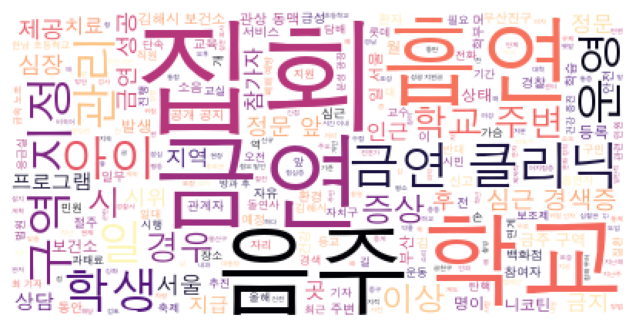

In [44]:
wordc = WordCloud(
            background_color='white',
            max_words=400,
            relative_scaling=0.3,
            colormap='magma',
            font_path=fontpath
)
# word = ' '.join(text)
wordc.generate(data_noun)
plt.figure(figsize=(10, 4))
plt.imshow(wordc)
plt.axis('off')
plt.show()

In [45]:
import nltk
import matplotlib.pyplot as plt
from konlpy.corpus import kolaw

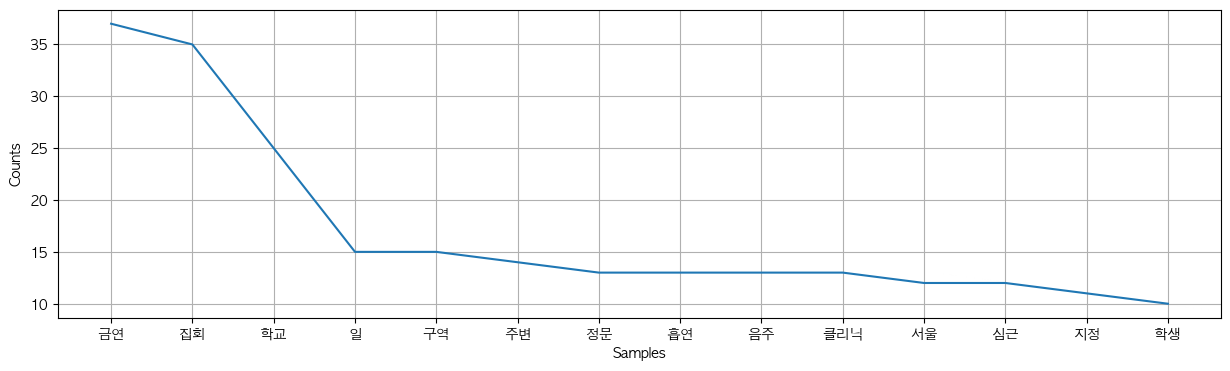

In [46]:
word_list = [word for word, tag in kkma_tagged_text if tag in ('NNG', 'NNP')]
data_text = nltk.Text(word_list)
words, counts = zip(*data_text.vocab().most_common(14))
plt.figure(figsize=(15, 4))
plt.plot(words, counts)
plt.xticks(rotation=0)
plt.xlabel('Samples')
plt.ylabel('Counts')
plt.grid()
plt.show()

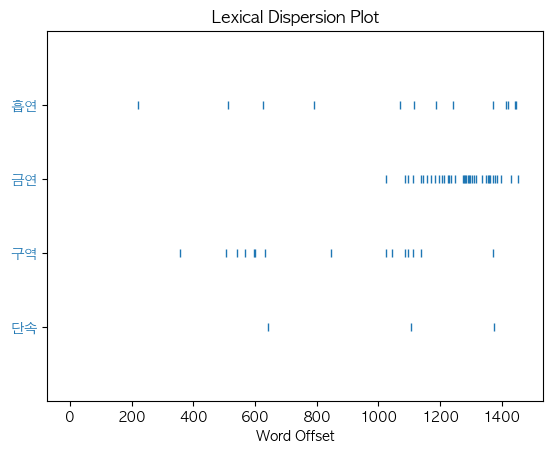

In [47]:
data_text.dispersion_plot(['흡연', '금연', '구역', '단속'])
plt.show()

# RNN

## 전처리

In [48]:
t = Tokenizer()
t.fit_on_texts([word_list])
encoded = t.texts_to_sequences([word_list])[0]
print(encoded)
print(t.word_index)

[4, 11, 139, 84, 45, 14, 140, 85, 32, 11, 266, 141, 142, 33, 3, 14, 56, 267, 143, 2, 268, 142, 6, 269, 270, 141, 86, 271, 87, 2, 46, 57, 58, 272, 34, 59, 144, 145, 146, 273, 274, 275, 14, 60, 61, 276, 62, 277, 61, 147, 2, 63, 148, 3, 6, 2, 149, 57, 150, 151, 278, 279, 152, 153, 4, 154, 21, 280, 281, 11, 155, 45, 282, 88, 283, 284, 14, 285, 156, 89, 90, 15, 3, 14, 286, 3, 6, 35, 2, 91, 3, 7, 287, 157, 11, 288, 289, 158, 92, 93, 290, 159, 2, 7, 157, 35, 291, 159, 2, 91, 35, 160, 2, 94, 3, 7, 35, 292, 86, 87, 2, 2, 158, 92, 93, 2, 293, 161, 294, 162, 295, 2, 3, 6, 57, 4, 11, 155, 45, 7, 16, 14, 62, 296, 64, 163, 149, 164, 85, 32, 3, 6, 297, 3, 7, 298, 56, 14, 3, 165, 299, 7, 16, 300, 301, 302, 303, 304, 7, 16, 305, 306, 307, 308, 64, 47, 166, 167, 17, 3, 309, 18, 153, 18, 310, 168, 311, 4, 11, 139, 84, 45, 7, 16, 169, 2, 36, 58, 36, 312, 95, 7, 16, 95, 313, 314, 32, 58, 2, 36, 7, 16, 96, 2, 65, 161, 17, 315, 6, 316, 317, 8, 34, 36, 64, 96, 318, 170, 56, 319, 97, 171, 14, 98, 172, 320, 173

In [49]:
print(t.texts_to_sequences(['흡연', '금연']))
print(t.texts_to_sequences(['흡연', '금연'])[0])

[[8], [1]]
[8]


In [50]:
print(t.texts_to_matrix(['흡연', '금연']))
print(t.texts_to_matrix(['흡연', '금연'])[0])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.


In [51]:
for word, value in t.word_index.items():
    if value == 1:
        print('1 : ', word)
        break

1 :  금연


In [52]:
key_to_find = '흡연'
values_with_key = [key for value, key in t.word_index.items() if value == key_to_find]

print(values_with_key)

[8]


In [53]:
# 한글만 남기고 나머지 문자(숫자, 특수문자 등)를 제거하는 함수
def remove_non_korean(sentence):
    return re.sub(r'[^가-힣\s]', '', sentence)

# 문장 리스트에서 한글만 남기고 필터링
filtered_sent_tokens = '.'.join([remove_non_korean(sentence) for sentence in sent_tokens])

# 결과 출력
print(filtered_sent_tokens)

    일 서울 용산구 한남초등학교에서 학생들이 하교하고 있다.최현규 기자서울 한남동 대통령 관저 인근 학교 학생과 학부모가 연일 계속되는 집회에 골머리를 앓고 있다.관저 주변에서 열리는 윤석열 대통령 탄핵 찬성 및 반대 집회에서 발생하는 소음뿐 아니라 일부 격앙된 시위 참여자의 비속어와 혐오 발언으로 험악한 분위기가 고조된 탓이다.학생들 교육 환경에 악영향을 미칠 뿐 아니라 안전을 위협하는 환경이라는 지적이 나온다.집회의 자유를 보장하면서도 학교 주변 집회에 대해선 소음 규제 등을 강화하는 대책 마련이 시급하다는 목소리가 커지고 있다지난 일 오후 시쯤 찾은 한남동 서울한남초등학교는 방학기간이어서 정규 수업이 열리지는 않았다.하지만 학생 여명이 돌봄교실과 방과후학교 등을 다니고 있어서 학생들 통행이 끊이지 않는다.학교 주변으로는 주로 곳에서 집회가 진행된다.학교 정문으로부터 쯤 떨어진 서울 지하철 호선 한강진역 일대엔 보수 단체의 집회가 열린다.정문에서 쯤 떨어진 곳에선 진보 단체의 집회가 진행된다이들 곳이 주요 집회 장소인데 학교 정문에서 불과  떨어진 곳에서도 소규모로 탄핵 반대 집회가 열린다.이 집회에선 한강진역 일대 집회 장면을 현장음과 함께 생중계한다.밤낮을 가리지 않고 집회가 이어지면서 학교 주변은 내내 소음이 끊이지 않는다일 서울한남초등학교 정문 앞에 학생들의 안전한 등하교를 위한 경찰통제선이 설치되어있다.최현규 기자학교 주변은 긴장감이 감돌았다.학교 정문은 철문으로 굳게 닫혀 있었다.학부모들과 학생들이 학교를 오갈 때만 잠시 정문 앞에서 대기하고 있던 교사가 문을 열어주면서 외부인 출입을 막고 있었다정문 앞에는 형광 조끼를 입은 기동대 경찰 명이 차량과 인파를 관리하고 있었다.학교 담벼락에는 우리 아이들 배움 위해 소리는 낮춰주세요 우리 아이들 위해 통학로는 지켜주세요라는 내용의 현수막이 걸려 있었다지난 일 서울 용산구 한남초등학교 정문 앞 거리에 집회 참가자들이 몰려 있다.일부 참가자들이 골목에서 담배를 피면서 정문 앞으로 담배 연기가 흘러 들

In [54]:
sequences = []
for line in str(filtered_sent_tokens).split('.'):
    print('원본 문장 : ', line)
    encoded = t.texts_to_sequences([line])[0]
    print('encoded된 문장 : ', encoded)
    print()
    for i in range(0, len(encoded)-1):
        for j in range(i+2, len(encoded)+1):
            sequences.append(encoded[i : j])
print('sequences와 해석 : ')
for sequence in sequences:
    print('[', end='')
    for word_seq in sequence:
        for word, value in t.word_index.items():
            if word_seq == value:
                print('{} : {}'.format(word_seq, word), end=' ')
                break
    print(']')

원본 문장 :      일 서울 용산구 한남초등학교에서 학생들이 하교하고 있다
encoded된 문장 :  [4, 11, 139]

원본 문장 :  최현규 기자서울 한남동 대통령 관저 인근 학교 학생과 학부모가 연일 계속되는 집회에 골머리를 앓고 있다
encoded된 문장 :  [266, 141, 142, 33, 3, 267]

원본 문장 :  관저 주변에서 열리는 윤석열 대통령 탄핵 찬성 및 반대 집회에서 발생하는 소음뿐 아니라 일부 격앙된 시위 참여자의 비속어와 혐오 발언으로 험악한 분위기가 고조된 탓이다
encoded된 문장 :  [142, 141, 86, 271, 87, 58, 34, 145]

원본 문장 :  학생들 교육 환경에 악영향을 미칠 뿐 아니라 안전을 위협하는 환경이라는 지적이 나온다
encoded된 문장 :  [60]

원본 문장 :  집회의 자유를 보장하면서도 학교 주변 집회에 대해선 소음 규제 등을 강화하는 대책 마련이 시급하다는 목소리가 커지고 있다지난 일 오후 시쯤 찾은 한남동 서울한남초등학교는 방학기간이어서 정규 수업이 열리지는 않았다
encoded된 문장 :  [3, 6, 57, 150, 278, 4, 154, 266, 283]

원본 문장 :  하지만 학생 여명이 돌봄교실과 방과후학교 등을 다니고 있어서 학생들 통행이 끊이지 않는다
encoded된 문장 :  [14]

원본 문장 :  학교 주변으로는 주로 곳에서 집회가 진행된다
encoded된 문장 :  [3]

원본 문장 :  학교 정문으로부터 쯤 떨어진 서울 지하철 호선 한강진역 일대엔 보수 단체의 집회가 열린다
encoded된 문장 :  [3, 157, 11, 288, 289, 290]

원본 문장 :  정문에서 쯤 떨어진 곳에선 진보 단체의 집회가 진행된다이들 곳이 주요 집회 장소인데 학교 정문에서 불과  떨어진 곳에서도 소규모로 탄핵 반대 집회가 열린다
encoded된 문장 :  [157, 291, 160, 2, 3, 86, 87]

원본 문장 :  이 집회에선 한강진역

In [55]:
sequences

[[4, 11],
 [4, 11, 139],
 [11, 139],
 [266, 141],
 [266, 141, 142],
 [266, 141, 142, 33],
 [266, 141, 142, 33, 3],
 [266, 141, 142, 33, 3, 267],
 [141, 142],
 [141, 142, 33],
 [141, 142, 33, 3],
 [141, 142, 33, 3, 267],
 [142, 33],
 [142, 33, 3],
 [142, 33, 3, 267],
 [33, 3],
 [33, 3, 267],
 [3, 267],
 [142, 141],
 [142, 141, 86],
 [142, 141, 86, 271],
 [142, 141, 86, 271, 87],
 [142, 141, 86, 271, 87, 58],
 [142, 141, 86, 271, 87, 58, 34],
 [142, 141, 86, 271, 87, 58, 34, 145],
 [141, 86],
 [141, 86, 271],
 [141, 86, 271, 87],
 [141, 86, 271, 87, 58],
 [141, 86, 271, 87, 58, 34],
 [141, 86, 271, 87, 58, 34, 145],
 [86, 271],
 [86, 271, 87],
 [86, 271, 87, 58],
 [86, 271, 87, 58, 34],
 [86, 271, 87, 58, 34, 145],
 [271, 87],
 [271, 87, 58],
 [271, 87, 58, 34],
 [271, 87, 58, 34, 145],
 [87, 58],
 [87, 58, 34],
 [87, 58, 34, 145],
 [58, 34],
 [58, 34, 145],
 [34, 145],
 [3, 6],
 [3, 6, 57],
 [3, 6, 57, 150],
 [3, 6, 57, 150, 278],
 [3, 6, 57, 150, 278, 4],
 [3, 6, 57, 150, 278, 4, 154],

In [56]:
print([len(sequence) for sequence in sequences])

[2, 3, 2, 2, 3, 4, 5, 6, 2, 3, 4, 5, 2, 3, 4, 2, 3, 2, 2, 3, 4, 5, 6, 7, 8, 2, 3, 4, 5, 6, 7, 2, 3, 4, 5, 6, 2, 3, 4, 5, 2, 3, 4, 2, 3, 2, 2, 3, 4, 5, 6, 7, 8, 9, 2, 3, 4, 5, 6, 7, 8, 2, 3, 4, 5, 6, 7, 2, 3, 4, 5, 6, 2, 3, 4, 5, 2, 3, 4, 2, 3, 2, 2, 3, 4, 5, 6, 2, 3, 4, 5, 2, 3, 4, 2, 3, 2, 2, 3, 4, 5, 6, 7, 2, 3, 4, 5, 6, 2, 3, 4, 5, 2, 3, 4, 2, 3, 2, 2, 3, 2, 2, 2, 3, 4, 5, 6, 7, 2, 3, 4, 5, 6, 2, 3, 4, 5, 2, 3, 4, 2, 3, 2, 2, 3, 4, 5, 6, 7, 8, 9, 2, 3, 4, 5, 6, 7, 8, 2, 3, 4, 5, 6, 7, 2, 3, 4, 5, 6, 2, 3, 4, 5, 2, 3, 4, 2, 3, 2, 2, 3, 2, 2, 2, 2, 3, 4, 5, 6, 7, 8, 9, 10, 2, 3, 4, 5, 6, 7, 8, 9, 2, 3, 4, 5, 6, 7, 8, 2, 3, 4, 5, 6, 7, 2, 3, 4, 5, 6, 2, 3, 4, 5, 2, 3, 4, 2, 3, 2, 2, 2, 3, 4, 2, 3, 2, 2, 3, 4, 2, 3, 2, 2, 3, 4, 2, 3, 2, 2, 3, 4, 5, 6, 2, 3, 4, 5, 2, 3, 4, 2, 3, 2, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 2, 3, 4, 5, 6, 7, 8, 9, 10, 2, 3, 4, 5, 6, 7, 8, 9, 2, 3,

In [57]:
my_len = max([len(sequence) for sequence in sequences])
my_len

18

In [58]:
padded_sequence = pad_sequences(sequences=sequences,
                                maxlen=my_len,
                                padding='pre')
type(padded_sequence), padded_sequence.shape, padded_sequence

(numpy.ndarray,
 (1347, 18),
 array([[  0,   0,   0, ...,   0,   4,  11],
        [  0,   0,   0, ...,   4,  11, 139],
        [  0,   0,   0, ...,   0,  11, 139],
        ...,
        [  0,   0,   0, ...,   0, 546,   6],
        [  0,   0,   0, ..., 546,   6, 676],
        [  0,   0,   0, ...,   0,   6, 676]], dtype=int32))

In [59]:
X = padded_sequence[:, :-1]
y = padded_sequence[:, -1:]

In [60]:
vocab_size = len(t.word_index)
vocab_size

679

In [61]:
Y = to_categorical(y, vocab_size+1)
Y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [62]:
X.shape, Y.shape

((1347, 17), (1347, 680))

## 모델 생성

In [63]:
model = Sequential()

model.add(Embedding(input_dim=vocab_size+1,
                    output_dim=vocab_size-1,
                    input_length=X.shape[1])
)
model.build((None, X.shape[1]))
model.add(SimpleRNN(units=64))
model.add(Dense(units=680, activation='softmax'))
print(model.summary())

/opt/anaconda3/envs/tf/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 17, 678)        │       461,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 64)             │        47,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 680)            │        44,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 552,792 (2.11 MB)

 Trainable params: 552,792 (2.11 MB)

 Non-trainable params: 0 (0.00 B)

None


## 학습과정 설정 및 학습하기

In [64]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
hist = model.fit(x=X, y=Y, epochs=300, verbose=2)

Epoch 1/300
43/43 - 1s - 13ms/step - accuracy: 0.0245 - loss: 5.8433
Epoch 2/300
43/43 - 0s - 4ms/step - accuracy: 0.0609 - loss: 4.8674
Epoch 3/300
43/43 - 0s - 5ms/step - accuracy: 0.0950 - loss: 4.6087
Epoch 4/300
43/43 - 0s - 5ms/step - accuracy: 0.2353 - loss: 4.2195
Epoch 5/300
43/43 - 0s - 4ms/step - accuracy: 0.3601 - loss: 3.7123
Epoch 6/300
43/43 - 0s - 4ms/step - accuracy: 0.4796 - loss: 3.1663
Epoch 7/300
43/43 - 0s - 4ms/step - accuracy: 0.5538 - loss: 2.6671
Epoch 8/300
43/43 - 0s - 4ms/step - accuracy: 0.6199 - loss: 2.2489
Epoch 9/300
43/43 - 0s - 4ms/step - accuracy: 0.6704 - loss: 1.9136
Epoch 10/300
43/43 - 0s - 4ms/step - accuracy: 0.7223 - loss: 1.6378
Epoch 11/300
43/43 - 0s - 4ms/step - accuracy: 0.7461 - loss: 1.4159
Epoch 12/300
43/43 - 0s - 4ms/step - accuracy: 0.7684 - loss: 1.2383
Epoch 13/300
43/43 - 0s - 5ms/step - accuracy: 0.7899 - loss: 1.1010
Epoch 14/300
43/43 - 0s - 4ms/step - accuracy: 0.8033 - loss: 0.9908
Epoch 15/300
43/43 - 0s - 4ms/step - accur

In [65]:
hist.history.keys()

dict_keys(['accuracy', 'loss'])

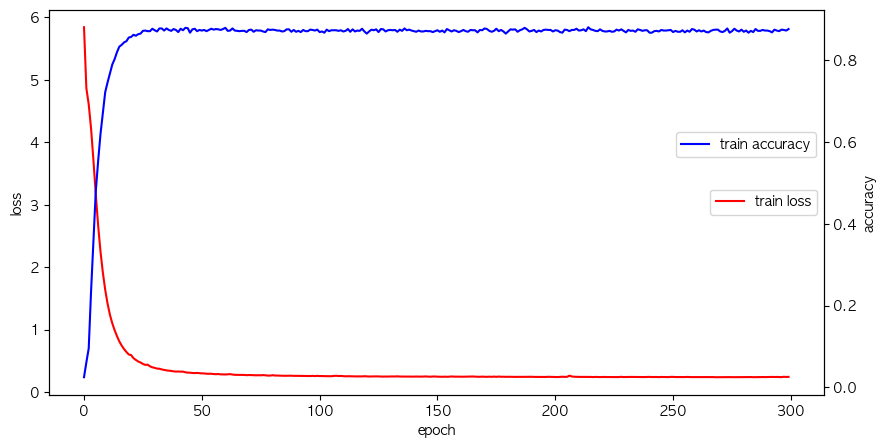

In [66]:
fig, loss_ax = plt.subplots(figsize=(10, 5))
loss_ax.plot(hist.history['loss'], 'r', label='train loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend(bbox_to_anchor=(0.999, 0.7))
plt.show()